## Problem: Detection of aggressive tweets

Training dataset has 12800 tweets (in english) and validation dataset has 3200 tweets.<br/>
Tweets are labeled (by human) as:
* 1 (Cyber-Aggressive; 9714 items)
* 0 (Non Cyber-Aggressive; 6286 items)

# Classification of Tweets

### Data

In [1]:
import pandas as pd
import numpy as np

In [2]:
data_train = pd.read_json('./Data/train.json')
data_valid = pd.read_json('./Data/valid.json')

In [3]:
X_train = data_train.content
y_train = data_train.label
X_test = data_valid.content
y_test = data_valid.label

### Advanced Preprocessing

In [4]:
from sklearn.base import TransformerMixin, BaseEstimator
import nltk
import string
import re

In [37]:
class AdvancedTextPreprocessor(BaseEstimator, TransformerMixin):
    
    def __init__(self, stopwords=[], punctuation='', stemming=False):
        self.stopwords = stopwords
        self.punctuation = punctuation
        self.stemming = stemming
    
    def fit(self, X, y=None):
        self.stopwords_set = set(self.stopwords)
        self.punctuation_set = set(self.punctuation)
        if self.stemming:
            self.stemmer = nltk.PorterStemmer()
        return self
    
    def keep_question_marks(self, X):
        self.punctuation_set = self.punctuation_set - {'?'}
        
    def keep_exclamation_marks(self, X):
        self.punctuation_set = self.punctuation_set - {'!'}
     
    def normalize_question_marks(self, X):
        # --> onequestionmark
        regex = '\\?{1}'
        X_normalized = [re.sub(regex, ' onequestionmark ', doc) for doc in X]
        
        # --> manyquestionmarks
        regex = '\\?{2,}'
        X_normalized = [re.sub(regex, ' manyquestionmarks ', doc) for doc in X_normalized]
        return X_normalized
    
    def normalize_exclamation_marks(self, X):
        # --> oneexclamationmark
        regex = '\\!{1}'
        X_normalized = [re.sub(regex, ' oneexclamationmark ', doc) for doc in X]
        
        # --> manyexclamationmarks
        regex = '\\!{2,}'
        X_normalized = [re.sub(regex, ' manyexclamationmarks ', doc) for doc in X_normalized]
        return X_normalized
    
    def normalize_repeating_letters(self, X):
        # letters repeated four or more times --> three times
        regex = '(([a-z])\\2{3,})'
        X_normalized = [re.sub(regex, '\\2\\2\\2', doc, flags=re.IGNORECASE) for doc in X]
        return X_normalized
    
    def normalize_laugh(self, X):
        # --> haha
        regex = '\\b(b?a?(ha|he)\\2{1,}h?)\\b'
        X_cleaned = [re.sub(regex, ' haha ', doc, flags=re.IGNORECASE) for doc in X]
        return X_cleaned
    
    def normalize_emoticons(self, X):
        # --> emoticonhappyface
        regex = '[:;=8x]-?[)D\\]*]'
        X_normalized = [re.sub(regex, ' emoticonhappyface ', doc) for doc in X]
        
        # --> emoticonsadface
        regex = '[:;=8x]\'?-?[/(x#|\[{]'
        X_normalized = [re.sub(regex, ' emoticonsadface ', doc) for doc in X_normalized]
        
        # --> emoticonheart
        regex = '<3+'
        X_normalized = [re.sub(regex, ' emoticonheart ', doc) for doc in X_normalized]
        return X_normalized
    
    def text_normalizer(self, X):        
        X_normalized = self.normalize_repeating_letters(X)        
        X_normalized = self.normalize_laugh(X_normalized)
        X_normalized = self.normalize_emoticons(X_normalized)
        
        X_normalized = self.normalize_question_marks(X_normalized)
        X_normalized = self.normalize_exclamation_marks(X_normalized)
        return X_normalized    
    
    def transform(self, X):
        X_normalized = self.text_normalizer(X)        
        
        # convert to lowercase
        X_lower = [doc.lower() for doc in X_normalized]  
#         X_lower = [doc.lower() for doc in X] 
        # split texts into words
        X_tokenized = [nltk.word_tokenize(doc) for doc in X_lower]
        # remove punctuation and stopwords
        X_tokenized = [[token for token in doc_tokenized 
                        if token not in self.punctuation_set and token not in self.stopwords_set]
                      for doc_tokenized in X_tokenized]
        
        # leave stems of words
        if self.stemming:
            X_tokenized = [[self.stemmer.stem(token) for token in doc_tokenized]
                          for doc_tokenized in X_tokenized]
            
        # join list of stems/words
        X_preprocessed = [' '.join(doc_tokenized)
                          for i, doc_tokenized in enumerate(X_tokenized)]        
        return X_preprocessed

In [38]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score

from myutils import *

In [7]:
STOPWORDS = nltk.corpus.stopwords.words('english')
IRRELEVANT_STOPWORDS = pd.read_csv('./Data/irrelevant_stopwords.csv', header=None)[0].values
PUNCTUATION = string.punctuation

In [8]:
token_pattern = '(?u)\\b\\w{2,}\\b'

In [9]:
# class_weight={0:1, 1:1.2}

In [39]:
pipe_advanced_baseline = Pipeline([
                ('preprocessor', AdvancedTextPreprocessor(stopwords=IRRELEVANT_STOPWORDS, 
                                                          punctuation=PUNCTUATION,
                                                          stemming=True)),
                ('vectorizer', CountVectorizer(token_pattern=token_pattern)),
                ('scaler', MaxAbsScaler()),
                ('clf', LogisticRegression(penalty='l2', C=1.0))
                ])

In [40]:
pipe_advanced_baseline.fit(X_train, y_train);

In [41]:
y_train_pred = pipe_advanced_baseline.predict(X_train)
y_test_pred = pipe_advanced_baseline.predict(X_test)

In [42]:
print('Tarining dataset: accuracy = %.3f' % accuracy_score(y_pred=y_train_pred, y_true=y_train))
print('Test dataset: accuracy = %.3f' % accuracy_score(y_pred=y_test_pred, y_true=y_test))

Tarining dataset: accuracy = 0.906
Test dataset: accuracy = 0.799


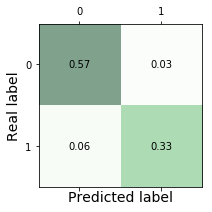

In [14]:
plot_confusion_matrix(y_train, y_train_pred)

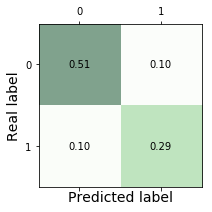

In [15]:
plot_confusion_matrix(y_test, y_test_pred)

But it is still overfitted

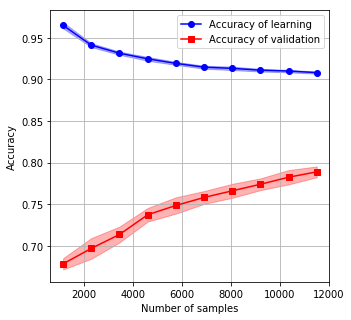

In [16]:
plot_learning_curve(estimator=pipe_advanced_baseline, X=X_train, y=y_train)

### Hyperparameter Tuning

In [70]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import Normalizer

from scipy.stats.distributions import uniform, randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from scipy.spatial.distance import cosine
from pprint import pprint

CountVectorizer: Term Frequency

In [43]:
pipe_tf = Pipeline([('preprocessor', AdvancedTextPreprocessor(punctuation=PUNCTUATION)),
                    ('vectorizer', CountVectorizer(token_pattern=token_pattern)),
                    ('scaler', MaxAbsScaler())
                   ])

param_dist_tf = {'transformers__preprocessor__stopwords': [IRRELEVANT_STOPWORDS, STOPWORDS, []],
                 'transformers__preprocessor__stemming': [True, False],
                 'transformers__vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)],
                 'transformers__vectorizer__min_df': randint(1, 10)
                }

In [20]:
from sklearn.base import clone

In [21]:
def count_no_features(pipe_trans, param_range, param_name, stemming):
    pipe = clone(pipe_trans)
    no_features = []
    for param in param_range:
        pipe.set_params(**{'preprocessor__stemming': stemming, param_name: param})
        dtm = pipe.fit_transform(X_train)
        no_features.append(dtm.shape[1])
    return no_features

def plot_no_features(pipe_trans, param_range, param_name, stemming):
    
    no_features = count_no_features(pipe_trans, param_range, param_name, stemming)
    
    fig, ax = plt.subplots(figsize=(5, 5))    
    ax.plot(param_range, no_features, '--o')
    ax.set_xlabel(param_name)
    ax.set_ylabel('Number of features')
    ax.set_title('Stemming = ' + str(stemming))
    ax.grid()
    plt.show()    

In [44]:
dtm = CountVectorizer().fit_transform(X_train)
dtm.shape

(12800, 13503)

In [45]:
inds = np.argwhere(dtm.sum(axis=0) == 1)[:, 1]
inds.shape

(6435,)

In [46]:
pipe_test = Pipeline([('preprocessor', AdvancedTextPreprocessor(punctuation=PUNCTUATION, stemming=False)),
                      ('vectorizer', CountVectorizer())])
dtm = pipe_test.fit_transform(X_train)
dtm.shape

(12800, 13359)

In [47]:
inds = np.argwhere(dtm.sum(axis=0) == 1)[:, 1]
inds.shape

(6328,)

In [49]:
np.array(pipe_test.named_steps['vectorizer'].get_feature_names())[inds][500:600]

array(['assholeman', 'assing', 'assistant', 'association', 'assuming',
       'assumption', 'assure', 'assured', 'asswhole', 'asta',
       'astronauts', 'aswesome', 'asz', 'atheist', 'athletic', 'ati',
       'atitude', 'atoms', 'atop', 'atrium', 'attempts', 'attending',
       'attic', 'attorney', 'ature', 'audio', 'aufeminin', 'aujala',
       'aural', 'aus', 'aussies', 'austinites', 'authentically', 'author',
       'authorities', 'automatic', 'autopilot', 'ava', 'avalanche',
       'avalon', 'avec', 'aveda', 'average', 'avflox', 'avid', 'avoided',
       'avril', 'awaiting', 'awash', 'awesomeee', 'awesomestt', 'awh',
       'awsome', 'awsomeee', 'awwesome', 'awwwz', 'axe', 'ayt', 'azn',
       'azz', 'b3', 'b3d', 'babaysitting', 'babershop', 'babeyy',
       'babeyyygirl', 'babie', 'babydoll', 'babyface_gm', 'babygirl',
       'babyyy', 'bach', 'backed', 'backtracks', 'badass', 'badd',
       'baddd', 'badevan', 'badge', 'badu', 'baggy', 'bahama', 'bahasa',
       'bail', 'bailey'

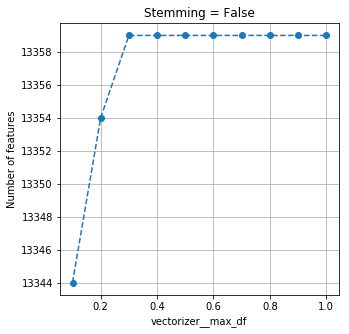

In [50]:
max_df_range = np.arange(0.1, 1.1, 0.1)
stemming = False
param_name = 'vectorizer__max_df'
plot_no_features(pipe_tf, max_df_range, param_name, stemming)

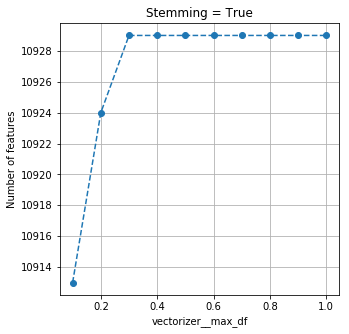

In [51]:
max_df_range = np.arange(0.1, 1.1, 0.1)
stemming = True
param_name = 'vectorizer__max_df'
plot_no_features(pipe_tf, max_df_range, param_name, stemming)

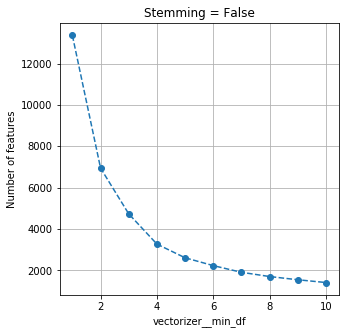

In [52]:
min_df_range = np.arange(1, 11, 1)
stemming = False
param_name = 'vectorizer__min_df'
plot_no_features(pipe_tf, min_df_range, param_name, stemming)

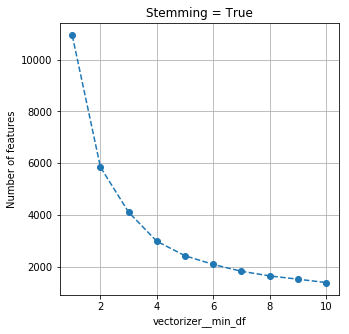

In [53]:
min_df_range = np.arange(1, 11, 1)
stemming = True
param_name = 'vectorizer__min_df'
plot_no_features(pipe_tf, min_df_range, param_name, stemming)

In [54]:
ngram_range = [(1, 1), (1, 2), (2, 2)]
stemming = False
param_name = 'vectorizer__ngram_range'
count_no_features(pipe_tf, ngram_range, param_name, stemming)

[13359, 82426, 69067]

In [55]:
ngram_range = [(1, 1), (1, 2), (2, 2)]
stemming = True
param_name = 'vectorizer__ngram_range'
count_no_features(pipe_tf, ngram_range, param_name, stemming)

[10929, 76932, 66003]

TfidfVectorizer: Term Frequency - Inverse Document Frequency

In [56]:
pipe_tfidf = Pipeline([('preprocessor', AdvancedTextPreprocessor(punctuation=PUNCTUATION)),
                       ('vectorizer', TfidfVectorizer(token_pattern=token_pattern, norm='l2'))
                      ])

param_dist_tfidf = {'transformers__preprocessor__stopwords': [IRRELEVANT_STOPWORDS, STOPWORDS, []],
                    'transformers__preprocessor__stemming': [True, False],
                    'transformers__vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)],
                    'transformers__vectorizer__min_df': randint(1, 10)
                   }

SVD: dimensionality reduction (Latent Semantic Indexing)

In [58]:
pipe_lsi = Pipeline([('preprocessor', AdvancedTextPreprocessor(punctuation=PUNCTUATION)),
                     ('vectorizer', TfidfVectorizer(token_pattern=token_pattern, norm='l2')),
                     ('svd', TruncatedSVD()),
                     ('normalizer', Normalizer())
                    ])

param_dist_lsi = {'transformers__preprocessor__stopwords': [IRRELEVANT_STOPWORDS, STOPWORDS, []],
                  'transformers__preprocessor__stemming': [True, False],
                  'transformers__vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)],
                  'transformers__vectorizer__min_df': randint(1, 10),
                  'transformers__svd__n_components': randint(100, 1000)
                 }

In [59]:
component_range = np.arange(100, 2000, 100)
explained_variance = []
for n in component_range:
    pipe_lsi.set_params(**{'svd__n_components': n})
    dtm = pipe_lsi.fit_transform(X_train)
    variance = pipe_lsi.named_steps['svd'].explained_variance_ratio_.sum()
    explained_variance.append(variance)

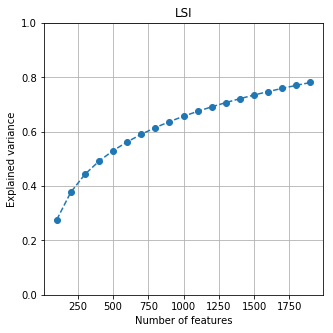

In [60]:
fig, ax = plt.subplots(figsize=(5, 5))    
ax.plot(component_range, explained_variance, '--o')
ax.set_xlabel('Number of features')
ax.set_ylabel('Explained variance')
ax.set_title('LSI')
ax.set_ylim(0, 1)
ax.grid()
plt.show()

In [61]:
pipe_lsi.set_params(**{'svd__n_components': 2})
dtm_svd = pipe_lsi.fit_transform(X_train)
print('Explained variance = %.3f' % pipe_lsi.named_steps['svd'].explained_variance_ratio_.sum())

Explained variance = 0.023


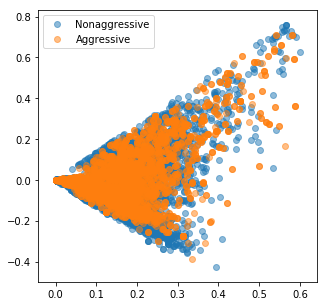

In [63]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(dtm_svd[y_train == 0, 0], dtm_svd[y_train == 0, 1], label='Nonaggressive', alpha=0.5)
ax.scatter(dtm_svd[y_train == 1, 0], dtm_svd[y_train == 1, 1], label='Aggressive', alpha=0.5)
plt.legend()
plt.show()

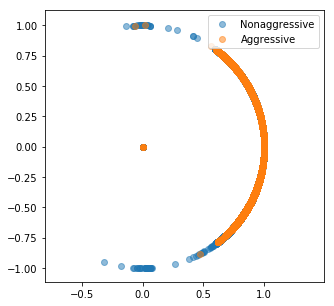

In [80]:
dtm_svd_normalized = Normalizer().fit_transform(dtm_svd)

fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(dtm_svd_normalized[y_train == 0, 0], dtm_svd_normalized[y_train == 0, 1], 
           label='Nonaggressive', alpha=0.5)
ax.scatter(dtm_svd_normalized[y_train == 1, 0], dtm_svd_normalized[y_train == 1, 1], 
           label='Aggressive', alpha=0.5)
plt.axis('equal')
plt.legend()
plt.show()

LatentDirichletAllocation

In [71]:
pipe_lda = Pipeline([('preprocessor', AdvancedTextPreprocessor(punctuation=PUNCTUATION)),
                     ('vectorizer', CountVectorizer(token_pattern=token_pattern)),
                     ('lda', LatentDirichletAllocation(learning_method='online'))
                    ])

param_dist_lda = {'transformers__preprocessor__stopwords': [IRRELEVANT_STOPWORDS, STOPWORDS, []],
                  'transformers__preprocessor__stemming': [True, False],
                  'transformers__vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)],
                  'transformers__vectorizer__min_df': randint(1, 10),
                  'transformers__lda__n_components': randint(2, 50),
                  'transformers__lda__doc_topic_prior': uniform(0.01, 3 - 0.01),
                  'transformers__lda__topic_word_prior': uniform(0.01, 3 - 0.01)
                 }

Transformers

In [72]:
transformers = [('tf', pipe_tf),
                ('tfidf', pipe_tfidf),
                ('lsi', pipe_lsi),
                ('lda', pipe_lda)                
               ]

param_dist_transformers = {'tf': param_dist_tf,
                           'tfidf': param_dist_tfidf,
                           'lsi': param_dist_lsi,
                           'lda': param_dist_lda
                          }

Estimators

In [73]:
estimators = {'lr': LogisticRegression(),
              'svm_lin': SVC(kernel='linear', probability=True),
              'svm_rbf': SVC(kernel='rbf', probability=True),
              'dt': DecisionTreeClassifier(),
              'knn': KNeighborsClassifier(),
              'nb': GaussianNB(),
              'lda': LinearDiscriminantAnalysis(),
              'qda': QuadraticDiscriminantAnalysis(),
             }

param_dist_estimators = {'lr': {'clf__penalty': ['l1', 'l2'],
                                'clf__C': uniform(0., 4.)},
                         'svm_lin': {'clf__C': uniform(0., 4.)},
                         'svm_rbf': {'clf__C': uniform(0., 4.),
                                     'clf__gamma': uniform(0.1, 3 - 0.1)},
                         'dt': {'clf__max_depth': randint(5, 15),
                                'clf__min_samples_leaf': randint(2, 40)},
                         'knn': {'clf__n_neighbors': randint(4, 15),
                                 'clf__metric': ['minkowski', cosine]},
                         'nb': {}, 
                         'lda': {},
                         'qda': {},
                        }

In [74]:
def search_best_clfs(clf_name):
    best_clfs = {}
    scores = pd.DataFrame(columns=[clf_name + '_train', clf_name + '_test'])

    for trans_name, trans_pipe in transformers:
        pipe = Pipeline([('transformers', trans_pipe),
                         ('clf', estimators[clf_name])])

        param_dist = param_dist_transformers[trans_name].copy()
        param_dist.update(param_dist_estimators[clf_name].items())

        rs = RandomizedSearchCV(estimator=pipe, param_distributions=param_dist, 
                                n_iter=20, n_jobs=1, refit=True,
                                scoring='accuracy',
                                cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=10))

        rs.fit(X_train, y_train)

        best_clfs.update({trans_name: rs.best_estimator_})

        train_score = rs.score(X_train, y_train)
        test_score = rs.score(X_test, y_test)
        scores.loc[trans_name] = [train_score, test_score]
        
    return best_clfs, scores

In [75]:
import pickle
import os

In [76]:
def save_model(model, file_name):
    models_path = './Models'
    if not os.path.exists(models_path):
        os.makedirs(models_path)
    
    with open(os.path.join(models_path, file_name), 'wb') as file:
        pickle.dump(model, file, protocol=4)

#### Logistic Regression

In [139]:
clf_name = 'lr'
best_lrs, lr_scores = search_best_clfs(clf_name)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20.

In [141]:
lr_scores

,train,test
tf,0.914609,0.798438
tfidf,0.890547,0.788438
lsi,0.742812,0.720000
lda,0.617656,0.612187


In [148]:
best_lrs[2].named_steps['transformers'].named_steps['svd'].explained_variance_ratio_.sum()

0.759866438048866

In [158]:
best_lrs[2].named_steps['transformers'].named_steps['svd'].get_params()

{'algorithm': 'randomized',
 'n_components': 371,
 'n_iter': 5,
 'random_state': None,
 'tol': 0.0}

In [ ]:
# clf_tf_lr2 = pipe_tf_lr2.named_steps['clf']

#### Linear SVM

In [171]:
clf_name = 'svm_lin'
best_lin_svms, lin_svm_scores = search_best_clfs(clf_name)

KeyboardInterrupt: 

#### SVM with kernel RBF

In [ ]:
clf_name = 'svm_rbf'
best_rbf_svms, rbf_svm_scores = search_best_clfs(clf_name)

#### Decision Tree

In [ ]:
clf_name = 'dt'
best_dts, dt_scores = search_best_clfs(clf_name)

#### K-Nearest Neighbors

In [ ]:
clf_name = 'knn'
best_knns, knn_scores = search_best_clfs(clf_name)

In [ ]:
clf_name = 'nb'
best_nbs, nb_scores = search_best_clfs(clf_name)

In [ ]:
clf_name = 'lda'
best_ldas, lda_scores = search_best_clfs(clf_name)

In [ ]:
clf_name = 'qda'
best_qdas, qda_scores = search_best_clfs(clf_name)

In [94]:
pipe = Pipeline([('preprocessor', AdvancedTextPreprocessor(punctuation=PUNCTUATION)),
                ('vectorizer', CountVectorizer(token_pattern=advanced_token_pattern)),
                ('scaler', MaxAbsScaler()),
                ('clf', LogisticRegression())
                ])

In [95]:
param_dist = {'preprocessor__stopwords': [IRRELEVANT_STOPWORDS, STOPWORDS, []],
              'preprocessor__stemming': [True, False],
              'vectorizer__max_df': uniform(0.5, 0.5),
              'vectorizer__min_df': randint(0, 10),
              'clf__penalty': ['l1', 'l2'],
              'clf__C': uniform(0., 4.)
              }

In [96]:
rs_tf_lr = RandomizedSearchCV(estimator=pipe, param_distributions=param_dist, 
                              n_iter=20, n_jobs=1, refit=True,
                              scoring='accuracy',
                              cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=10))

In [97]:
rs_tf_lr.fit(X_train, y_train);

In [98]:
rs_tf_lr.best_score_

0.739140625

In [99]:
print('Tarining dataset: accuracy = %.3f' % rs_tf_lr.score(X_train, y_train))
print('Test dataset: accuracy = %.3f' % rs_tf_lr.score(X_test, y_test))

Tarining dataset: accuracy = 0.847
Test dataset: accuracy = 0.759


We can look at the learning and validation curve to check overfitting/underfitting

In [100]:
pprint.pprint(rs_tf_lr.best_params_)

{'clf__C': 1.6721912988698895,
 'clf__penalty': 'l2',
 'preprocessor__stemming': True,
 'preprocessor__stopwords': ['i',
                             'me',
                             'my',
                             'myself',
                             'we',
                             'our',
                             'ours',
                             'ourselves',
                             'you',
                             "you're",
                             "you've",
                             "you'll",
                             "you'd",
                             'your',
                             'yours',
                             'yourself',
                             'yourselves',
                             'he',
                             'him',
                             'his',
                             'himself',
                             'she',
                             "she's",
                             'her',
             

In [101]:
pipe_tf_lr = rs_tf_lr.best_estimator_

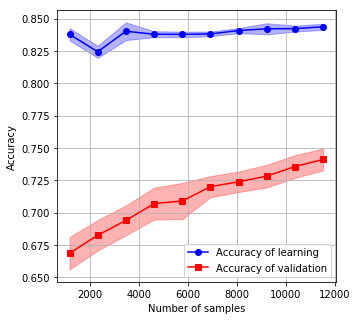

In [102]:
plot_learning_curve(estimator=pipe_tf_lr, X=X_train, y=y_train)

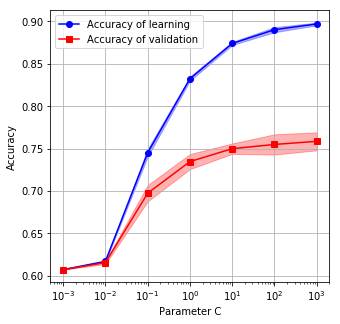

In [103]:
plot_validation_curve(estimator=pipe_tf_lr, X=X_train, y=y_train, 
                      param_name='clf__C', param_range=np.logspace(-3, 3, 7), x_scale='log')

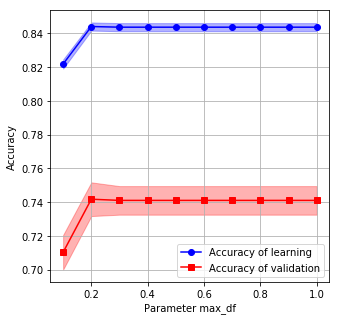

In [104]:
plot_validation_curve(estimator=pipe_tf_lr, X=X_train, y=y_train, 
                      param_name='vectorizer__max_df', param_range=np.linspace(0.1, 1., 10))

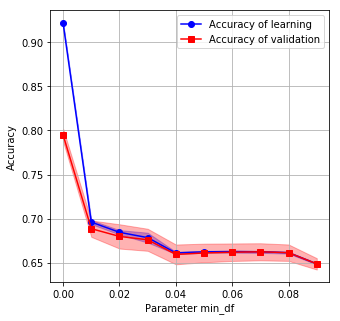

In [105]:
plot_validation_curve(estimator=pipe_tf_lr, X=X_train, y=y_train, 
                      param_name='vectorizer__min_df', param_range=np.linspace(0., 0.09, 10))

In [106]:
pprint.pprint(rs_tf_lr.best_params_)

{'clf__C': 1.6721912988698895,
 'clf__penalty': 'l2',
 'preprocessor__stemming': True,
 'preprocessor__stopwords': ['i',
                             'me',
                             'my',
                             'myself',
                             'we',
                             'our',
                             'ours',
                             'ourselves',
                             'you',
                             "you're",
                             "you've",
                             "you'll",
                             "you'd",
                             'your',
                             'yours',
                             'yourself',
                             'yourselves',
                             'he',
                             'him',
                             'his',
                             'himself',
                             'she',
                             "she's",
                             'her',
             

In [107]:
pipe_tf_lr.steps

[('preprocessor',
  AdvancedTextPreprocessor(punctuation='!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~',
               stemming=True,
               stopwords=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', ... 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"])),
 ('vectorizer',
  CountVectorizer(analyzer='word', binary=False, decode_error='strict',
          dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
          lowercase=True, max_df=0.6963137222540505, max_features=None,
          min_df=4, ngram_range=(1, 1), preprocessor=None, stop_words=None,
          strip_accents=None,
          token_pattern='(?u)\\b[:;=8x]-?[)D\\]*]|<3|\\?{1,}|\\w{2,}\\b',
          tokenizer=None, vocabulary=No

In [34]:
pipe_tf_lr2 = Pipeline([('preprocessor', AdvancedTextPreprocessor(punctuation=PUNCTUATION,
                                                                  stemming=False,
                                                                  stopwords=IRRELEVANT_STOPWORDS)),
                        ('vectorizer', CountVectorizer(token_pattern=advanced_token_pattern,
                                                       max_df=0.5, min_df=0.003)),
                        ('scaler', MaxAbsScaler()),
                        ('clf', LogisticRegression(penalty='l1', C=2))
                        ])

In [35]:
pipe_tf_lr2.fit(X_train, y_train);

In [36]:
y_train_pred = pipe_tf_lr2.predict(X_train)
y_test_pred = pipe_tf_lr2.predict(X_test)

In [37]:
print('Tarining dataset: accuracy = %.3f' % accuracy_score(y_pred=y_train_pred, y_true=y_train))
print('Test dataset: accuracy = %.3f' % accuracy_score(y_pred=y_test_pred, y_true=y_test))

Tarining dataset: accuracy = 0.747
Test dataset: accuracy = 0.723


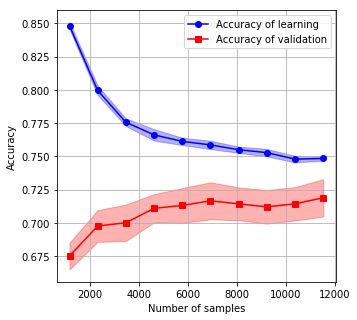

In [38]:
plot_learning_curve(estimator=pipe_tf_lr2, X=X_train, y=y_train)

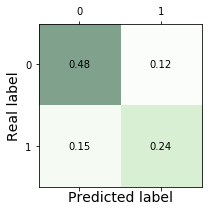

In [63]:
plot_confusion_matrix(y_test, y_test_pred)

In [66]:
best_pipe_tf_lr = pipe_tf_lr2

In [40]:
models_path = './Models'
if not os.path.exists(models_path):
    os.makedirs(models_path)

In [41]:
# save the model
with open(os.path.join(models_path, 'tf_logistic_regression.p'), 'wb') as file:
    pickle.dump(best_pipe_tf_lr, file, protocol=4)

In [42]:
with open(os.path.join(models_path, 'tf_logistic_regression.p'), 'rb') as file:
    loaded_model = pickle.load(file)

In [43]:
loaded_model.score(X_test, y_test)

0.7234375

#### TfidfVectorizer: Term Frequency - Inverse Document Frequency

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [51]:
pipe_tfidf_lr = Pipeline([('preprocessor', AdvancedTextPreprocessor(punctuation=PUNCTUATION)),
                          ('vectorizer', TfidfVectorizer(token_pattern=advanced_token_pattern, norm='l2')),
                          ('clf', LogisticRegression())
                         ])

In [52]:
param_dist = {'preprocessor__stopwords': [IRRELEVANT_STOPWORDS, STOPWORDS, []],
              'preprocessor__stemming': [True, False],
              'vectorizer__max_df': uniform(0.5, 0.5),
              'vectorizer__min_df': randint(0, 100),
              'clf__penalty': ['l1', 'l2'],
              'clf__C': uniform(0., 4.)
              }

In [53]:
rs_tfidf_lr = RandomizedSearchCV(estimator=pipe_tfidf_lr, param_distributions=param_dist, 
                                 n_iter=20, n_jobs=1, refit=True,
                                 scoring='accuracy',
                                 cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=10))

In [54]:
rs_tfidf_lr.fit(X_train, y_train);

In [55]:
rs_tfidf_lr.best_score_

0.717421875

In [56]:
print('Tarining dataset: accuracy = %.3f' % rs_tfidf_lr.score(X_train, y_train))
print('Test dataset: accuracy = %.3f' % rs_tfidf_lr.score(X_test, y_test))

Tarining dataset: accuracy = 0.744
Test dataset: accuracy = 0.724


In [57]:
pprint.pprint(rs_tfidf_lr.best_params_)

{'clf__C': 0.6627234562113027,
 'clf__penalty': 'l1',
 'preprocessor__stemming': False,
 'preprocessor__stopwords': ['i',
                             'me',
                             'my',
                             'myself',
                             'we',
                             'our',
                             'ours',
                             'ourselves',
                             'you',
                             "you're",
                             "you've",
                             "you'll",
                             "you'd",
                             'your',
                             'yours',
                             'yourself',
                             'yourselves',
                             'he',
                             'him',
                             'his',
                             'himself',
                             'she',
                             "she's",
                             'her',
            

In [58]:
pipe_tfidf_lr = rs_tfidf_lr.best_estimator_

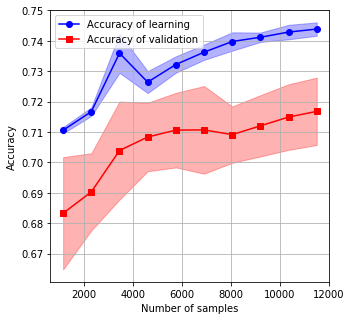

In [59]:
plot_learning_curve(estimator=pipe_tfidf_lr, X=X_train, y=y_train)

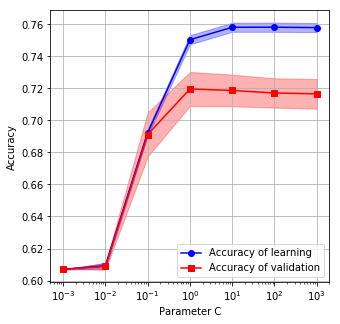

In [60]:
plot_validation_curve(estimator=pipe_tfidf_lr, X=X_train, y=y_train, 
                      param_name='clf__C', param_range=np.logspace(-3, 3, 7), x_scale='log')

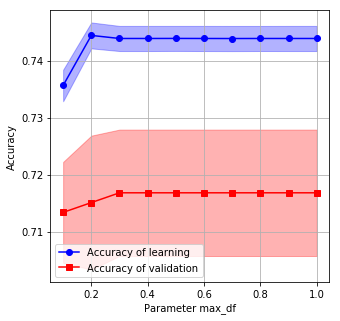

In [61]:
plot_validation_curve(estimator=pipe_tfidf_lr, X=X_train, y=y_train, 
                      param_name='vectorizer__max_df', param_range=np.linspace(0.1, 1., 10))

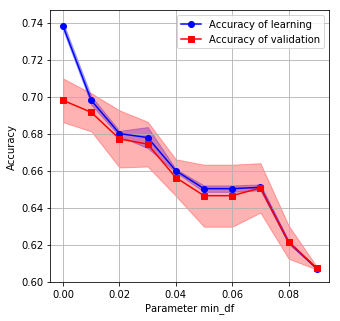

In [62]:
plot_validation_curve(estimator=pipe_tfidf_lr, X=X_train, y=y_train, 
                      param_name='vectorizer__min_df', param_range=np.linspace(0., 0.09, 10))

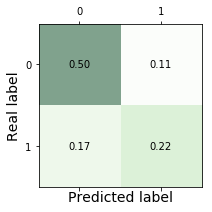

In [64]:
plot_confusion_matrix(y_test, rs_tfidf_lr.predict(X_test))

In [93]:
pipe_tfidf_lr2 = Pipeline([('preprocessor', AdvancedTextPreprocessor(punctuation=PUNCTUATION,
                                                                  stemming=False,
                                                                  stopwords=IRRELEVANT_STOPWORDS)),
                        ('vectorizer', TfidfVectorizer(
                                                    token_pattern=advanced_token_pattern,
                                                       max_df=1., min_df=4)),
                        ('clf', LogisticRegression(penalty='l2', C=0.9))
                        ])

pipe_tfidf_lr2.fit(X_train, y_train);

y_train_pred = pipe_tfidf_lr2.predict(X_train)
y_test_pred = pipe_tfidf_lr2.predict(X_test)

print('Tarining dataset: accuracy = %.3f' % accuracy_score(y_pred=y_train_pred, y_true=y_train))
print('Test dataset: accuracy = %.3f' % accuracy_score(y_pred=y_test_pred, y_true=y_test))

Tarining dataset: accuracy = 0.807
Test dataset: accuracy = 0.755


In [22]:

from sklearn.pipeline import FeatureUnion

In [ ]:
# clf_tf_lr2 = pipe_tf_lr2.named_steps['clf']

In [ ]:
pipe_tf_trans = FeatureUnion([('preprocessor', AdvancedTextPreprocessor(punctuation=PUNCTUATION,
                                                                           stemming=True,
                                                                           stopwords=IRRELEVANT_STOPWORDS)),
                                 ('vectorizer', CountVectorizer(token_pattern=advanced_token_pattern,
                                                                max_df=0.65, min_df=0.0003)),
                                 ('scaler', MaxAbsScaler())
                                ])

In [ ]:
# pipe_tf_lr = Pipeline([('transformers', pipe_tf_trans),
#                        ('clf', LogisticRegression(penalty='l2', C=))
#                       ])

In [ ]:
pipe = Pipeline([('preprocessor', AdvancedTextPreprocessor(punctuation=PUNCTUATION)),
                ('vectorizer', CountVectorizer(token_pattern=advanced_token_pattern)),
                ('scaler', MaxAbsScaler()),
                ('clf', LogisticRegression())
                ])

param_dist = {'preprocessor__stopwords': [IRRELEVANT_STOPWORDS, STOPWORDS, []],
              'preprocessor__stemming': [True, False],
              'vectorizer__max_df': uniform(0.5, 0.5),
              'vectorizer__min_df': randint(0, 100),
              'clf__penalty': ['l1', 'l2'],
              'clf__C': uniform(0., 4.)
              }

rs_tf_lr = RandomizedSearchCV(estimator=pipe, param_distributions=param_dist, 
                              n_iter=20, n_jobs=1, refit=True,
                              scoring='accuracy',
                              cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=10))